In [1]:
from servicex import ServiceXDataset
from coffea.processor.servicex import DataSource, Analysis
from coffea.processor.servicex import LocalExecutor
from func_adl_servicex import ServiceXSourceXAOD 

import matplotlib.pyplot as plt

from coffea import hist, processor
from IPython.display import display, update_display, HTML

Creating the datasets - mark `ignore_cache` true to force a re-submission to the backend.

In [2]:
dids = ['mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00']
datasets = [
    ServiceXDataset(did, backend_name='atlas_xaod', ignore_cache=False)
    for did in dids
]

In [3]:
leptons_per_event_query = ServiceXSourceXAOD('dummy_dataset') \
        .Select(lambda e: e.Electrons("Electrons")) \
        .Select(lambda eles: eles.Where(lambda e: e.pt()/1000.0 > 30.0)) \
        .Select(lambda eles: eles.Where(lambda e: abs(e.eta()) < 2.5)) \
        .Where(lambda eles: len(eles) == 2) \
        .Select(lambda ls: {
                'electrons_pt': ls.Select(lambda e: e.pt()/1000.0),
                'electrons_eta': ls.Select(lambda e: e.eta()),
                'electrons_phi': ls.Select(lambda e: e.phi()),
                'electrons_mass': ls.Select(lambda e: e.m()/1000.0),
                'electrons_charge': ls.Select(lambda e: e.charge())
        })

Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.
Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.


In [4]:
datasource = DataSource(query=leptons_per_event_query, metadata={'dataset-nickname': 'Zee'}, datasets=datasets)

In [5]:
class Z_EEAnalysis(Analysis):
    @staticmethod
    def process(events):
        import awkward as ak
        from collections import defaultdict

        sumw = defaultdict(float)
        mass_hist = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("mass", "$Z_{ee}$ [GeV]", 60, 60, 120),
        )

        dataset = events.metadata['dataset-nickname']

        electrons = events.electrons

        # Form the invar mass, plot.
        cut = (ak.num(electrons) == 2)
        diele = electrons[cut][:, 0] + electrons[cut][:, 1]

        sumw[dataset] += len(events)
        mass_hist.fill(
            dataset=dataset,
            mass=diele.mass,
        )
        
        return {
            "sumw": sumw,
            "mass": mass_hist
        }

In [6]:
analysis = Z_EEAnalysis()
executor = LocalExecutor()

Zee_2:   0%|          | 0/9000000000.0 [00:00]

        Zee_2 Downloaded:   0%|          | 0/9000000000.0 [00:00]

{'sumw': defaultdict(<class 'float'>, {'Zee': 50000.0}), 'mass': <Hist (dataset,mass) instance at 0x1bbb8800f40>}


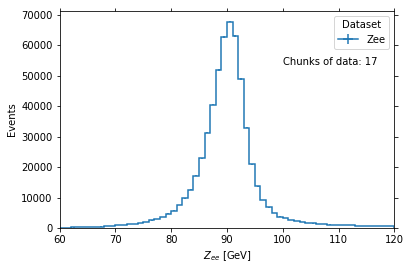

{'sumw': defaultdict(<class 'float'>, {'Zee': 200000.0}), 'mass': <Hist (dataset,mass) instance at 0x1bbb8800f40>}
{'sumw': defaultdict(<class 'float'>, {'Zee': 350000.0}), 'mass': <Hist (dataset,mass) instance at 0x1bbb8800f40>}
{'sumw': defaultdict(<class 'float'>, {'Zee': 395000.0}), 'mass': <Hist (dataset,mass) instance at 0x1bbb8800f40>}
{'sumw': defaultdict(<class 'float'>, {'Zee': 545000.0}), 'mass': <Hist (dataset,mass) instance at 0x1bbb8800f40>}
{'sumw': defaultdict(<class 'float'>, {'Zee': 695000.0}), 'mass': <Hist (dataset,mass) instance at 0x1bbb8800f40>}
{'sumw': defaultdict(<class 'float'>, {'Zee': 845000.0}), 'mass': <Hist (dataset,mass) instance at 0x1bbb8800f40>}
{'sumw': defaultdict(<class 'float'>, {'Zee': 895000.0}), 'mass': <Hist (dataset,mass) instance at 0x1bbb8800f40>}
{'sumw': defaultdict(<class 'float'>, {'Zee': 1045000.0}), 'mass': <Hist (dataset,mass) instance at 0x1bbb8800f40>}
{'sumw': defaultdict(<class 'float'>, {'Zee': 1095000.0}), 'mass': <Hist (datas

In [7]:
%matplotlib inline
async def plot_stream(accumulator_stream):
  global first
  fig, axes = plt.subplots()
  first = True


  count = 0
  async for coffea_info in accumulator_stream:
    print(coffea_info)
    hist.plot1d(coffea_info['mass'], ax=axes)

    count += 1
    plt.text(0.95, 0.75, f'Chunks of data: {count}', horizontalalignment='right', transform=axes.transAxes)

    # Either display it or update a previous version of the plot
    if first:
        display(fig, display_id='mass_update')
        first = False
    else:
        update_display(fig, display_id='mass_update')
  return coffea_info

await plot_stream(executor.execute(analysis, datasource, title='Zee_2'))
plt.close()  # Prevents another copy of the plot showing up in the notebook